# Comparison: Year 2014, Old: 201905r New:201905r_wrap

In [2]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr

from salishsea_tools import visualisations as vis
from salishsea_tools import viz_tools

%matplotlib inline

In [3]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [4]:
year = '2014'
olddir = 'v201905r'
newdir = 'v201905r_wrap'

In [5]:
def surface_plots(tracers, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=False, olddir=olddir, d201905=False, zoom=[0, 0, 0, 0], dl=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
            f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')

    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    if twoD:
        mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0, 0])
    else:
        mean_field = np.ma.array(dm[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[0].pcolormesh(mean_field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[0].set_title(olddir)
    fig.colorbar(colours, ax=axs[0])
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]
    
    if twoD:
        field = np.ma.array(ds[tracer][0], mask=1-tmask[0,0])
    else:
        field = np.ma.array(ds[tracer][0, dl], mask=1-tmask[0, dl])
    colours = axs[1].pcolormesh(field, cmap=cmap, vmax=vmax, vmin=vmin)
    axs[1].set_title(newdir)
    fig.colorbar(colours, ax=axs[1])
    
    colours = axs[2].pcolormesh(field-mean_field, cmap=cdiff, vmax=dvmax, vmin=-dvmax)
    axs[2].set_title("New - Old")
    fig.colorbar(colours, ax=axs[2])
    ds.close()
    dm.close()

    for ax in axs:
        viz_tools.set_aspect(ax)
        if sum(zoom) > 0:
            ax.set_ylim(zoom[0], zoom[1])
            ax.set_xlim(zoom[2], zoom[3])

    return fig

In [6]:
def profiles(tracers, file, olddir=olddir, d201905=False, dosum=False, zmax=39):
    zvalid = zmax
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
    
    
    mean_field = np.ma.array(dm[tracer][0], mask=1-tmask[0])
    stdev_mean = np.empty(zvalid)
    for iz in range(zvalid):
        stdev_mean[iz] = mean_field[iz].flatten().std()
    axs[0].plot(mean_field.mean(axis=1).mean(axis=1), deptht, linewidth=2, label='Old')
    axs[1].plot(np.zeros_like(deptht), deptht, linewidth=2, label='Old')
    
    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.ma.array(ds[tracer][0], mask=1-tmask[0])
    stdev_new = np.empty(zvalid)
    for iz in range(zvalid):
        stdev_new[iz] = field[iz].flatten().std()
    axs[0].plot(field.mean(axis=1).mean(axis=1), deptht, label='New')
    axs[0].set_title('Mean Profiles')
    
    axs[1].plot((field-mean_field).mean(axis=1).mean(axis=1), deptht, label='New')
    print (mean_field.mean(axis=1).mean(axis=1).max(), field.mean(axis=1).mean(axis=1).max())
    axs[1].set_title('Differences in Profiles')
    
    rmsd = np.empty(zvalid)
    for iz in range(zvalid):
        rmsd[iz] = np.sqrt(((field[iz] - mean_field[iz])**2).mean(axis=0).mean(axis=0))
        
    axs[2].plot(stdev_mean, deptht[:zvalid], label="Old")
    axs[2].plot(stdev_new, deptht[:zvalid], label="New")
    axs[2].plot(rmsd, deptht[:zvalid], label="RMSD")
    axs[2].set_title("Standard Deviations and RMS Difference")
    
    for ax in axs:    
        ax.invert_yaxis()
        ax.legend(loc='best')
        ax.grid(axis='y')
    
    ratio_ax = axs[2].twiny()
    ratio_ax.plot(rmsd/stdev_new, deptht[:zvalid], c='tab:red')
    
    print ((rmsd/stdev_new).max())
    
    
    ds.close()
    dm.close()

    ratio_ax.plot([0.1, 0.1], [deptht[0], deptht[zvalid]], 'k-')
    
    return fig

In [7]:
def thalweg_plots(tracers, file, cmap, cdiff, vmax, vmin, dvmax, olddir=olddir, d201905=False, maxdepth=0, dosum=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    if d201905:
        dm = xr.open_dataset(f'/results/SalishSea/month-avg.201905/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    else:
        dm = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{olddir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        dm['summed'] = 0.*dm[tracers[0]]
        for tr in tracers:
            dm['summed'] = dm['summed'] + dm[tr]
        tracer = 'summed'
    else:
        tracer = tracers
        
    mean_field = np.array(dm[tracer][0])
    colours = vis.contour_thalweg(axs[0], mean_field, bathy, mesh, np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)
    axs[0].set_title(olddir)

    ds = xr.open_dataset(
        f'/data/sallen/results/MEOPAR/{newdir}/SalishSea_1m_{year}{month}_{year}{month}_{file}_T.nc')
    
    if dosum:
        ds['summed'] = 0.*ds[tracers[0]]
        for tr in tracers:
            ds['summed'] = ds['summed'] + ds[tr]

    field = np.array(ds[tracer][0])
    colours = vis.contour_thalweg(axs[1], field, bathy, mesh,np.arange(vmin, 1.1*vmax+0.1*vmin, (vmax-vmin)/10.), cmap=cmap)

    axs[1].set_title(newdir)
    colours = vis.contour_thalweg(axs[2], field-mean_field, bathy, mesh, np.arange(-dvmax, 1.2*dvmax, dvmax/5), 
                                      cmap=cdiff)
 
    axs[2].set_title('New - Old')
    if maxdepth > 0:
        for ax in axs:
            ax.set_ylim(maxdepth, 0)
    ds.close()
    dm.close()

    fig.tight_layout()
    return fig

### Temperature ###

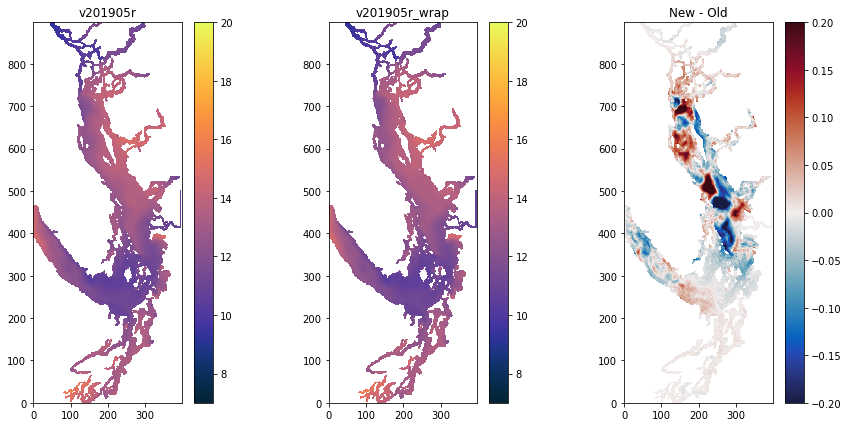

In [8]:
tracer = 'votemper'
file = 'grid'
month = '10'
cmap = cm.thermal
cdiff = cm.balance
vmax = 20
vmin = 7
dvmax = 0.2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

12.481565460666104 12.472551979630039
0.2727449716978787


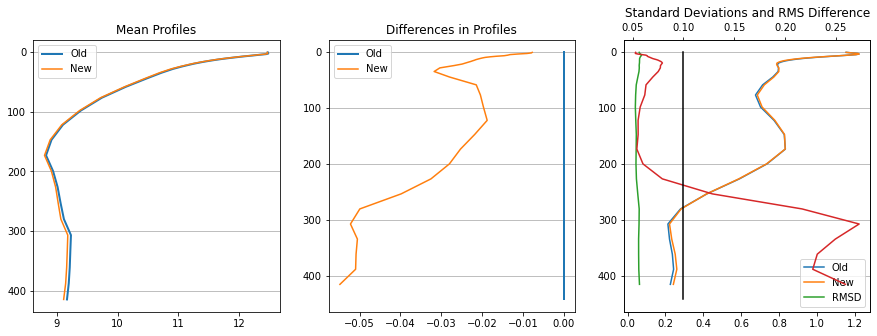

In [ ]:
fig = profiles(tracer, file)

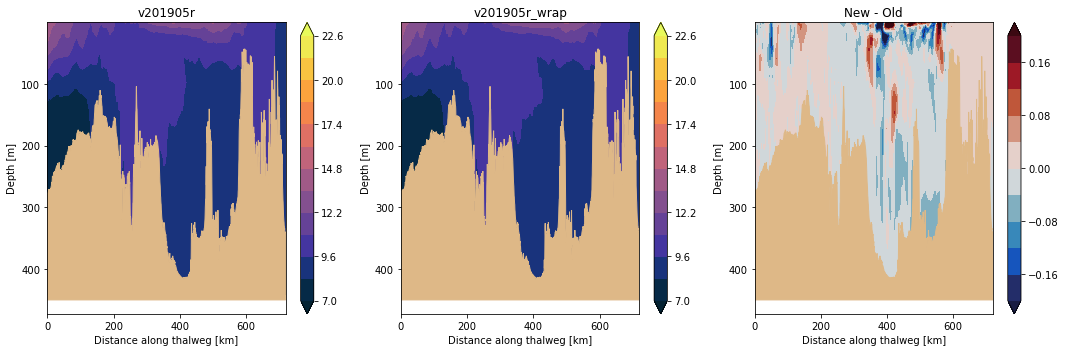

In [ ]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: max on profile -0.08(deep) to -0.01, mostly good to 190 m
* February: max on profile -0.08(deep) to -0.01, just above good to 200 m, actually good to 5 m
* March: max on profile -0.08 -0.65(deep) to 0.0, good to 5 m
* April: max on profile -0.08 -0.65(deep) to 0, good to 5 m
* May: max on profile -0.07 -0.65(deep) to -0.01, good to 240m
* June: max -0.065(deep) to 0, good to 260m
* July: max -0.065 -0.055(deep) to 0.01, good to 260m
* August: max -0.06-0.055(deep) to -0.02, good to 260m
* September: max -0.06 -0.055(deep) to -0.01, good to 240m
* October: max -0.055(deep) to -0.01, good to 240m
* November: max -0.08 -0.05(deep) to -0.02, good to 180m
* December: max -0.08 -0.55(deep) to 0

### Nitrate ###

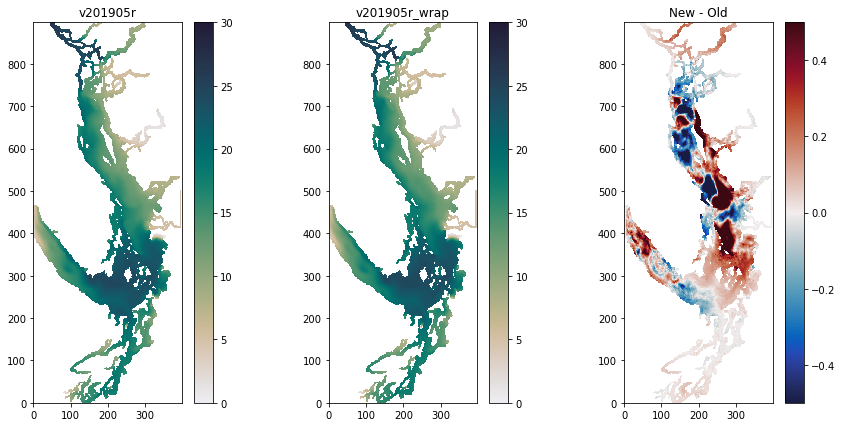

In [11]:
tracer = 'nitrate'
file = 'ptrc'
cmap = cm.rain
cdiff = cm.balance
vmax = 30
vmin = 0
dvmax = 0.5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

28.955199629524035 29.725168947558533
0.9763156807383279


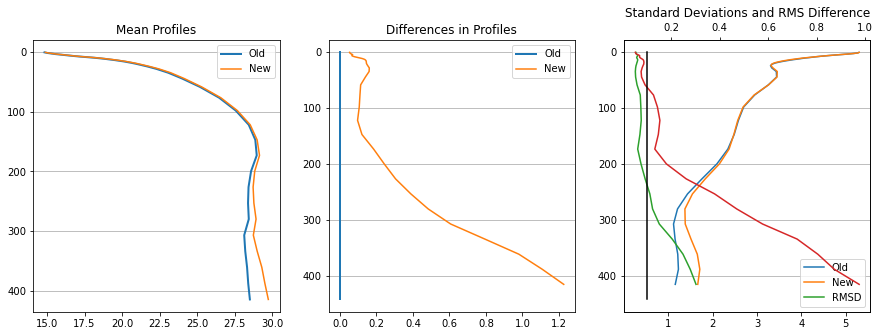

In [12]:
fig = profiles(tracer, file)

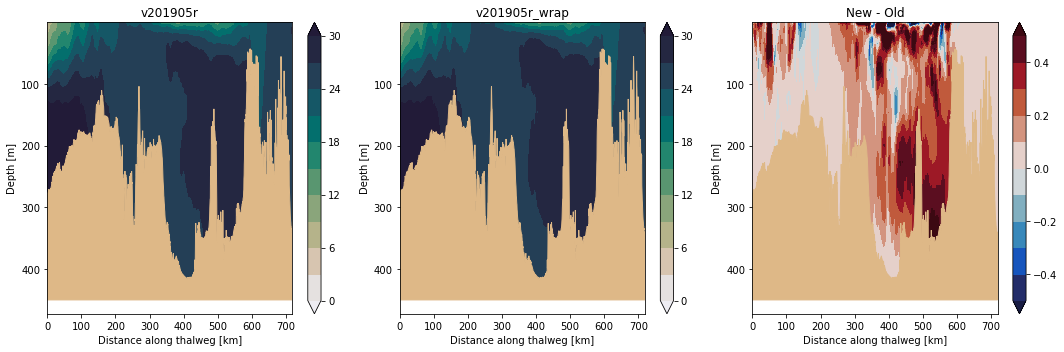

In [13]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: a bit more throughout, 0.1 to 1.1(deep) good to 10 m
* February: clearly more throughout max on profile 0.1 to 1.0(deep) no good
* March: max on profile 0 to 1.0(deep) good to 5m
* April: max on profile 0.1 to 1.0(deep) good to 5m
* May: max on profile 0.15 to 0.95(deep), mostly good to 90m
* June: max on profile 0.05 to 0.95(deep), mostly good to 90m
* July: max on profile 0.0 to 0.95(deep), good to 90m
* August: max on profile 0.0 to 0.85(deep), good to 70m
* September: max on profile 0 to 0.85(deep), good to 20m
* October: max on profile 0.05 to 1.2(deep), good to 60m
* November: max on profile 0.1 to 0.75(deep), good to 5 m
* December: max on profile 0.1 to 1.1(deep), good to 5 m

### Diatoms ###

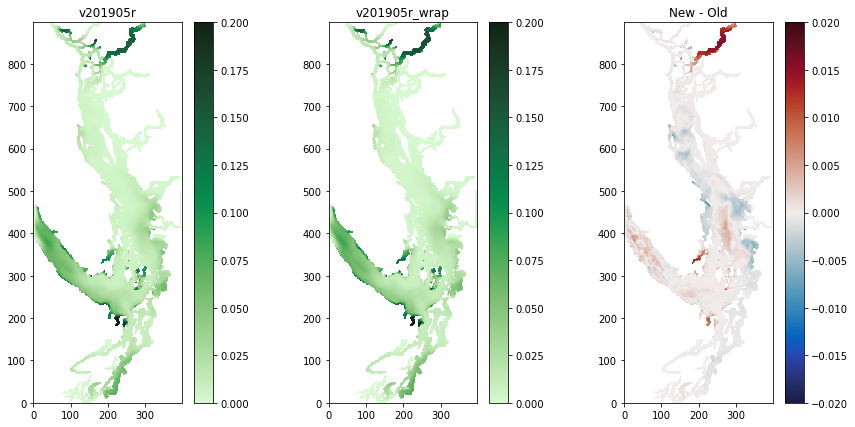

In [17]:
tracer = 'diatoms'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.2
vmin = 0
dvmax = 0.02
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)


0.026944614508438405 0.027107864872933263
0.073154394730328


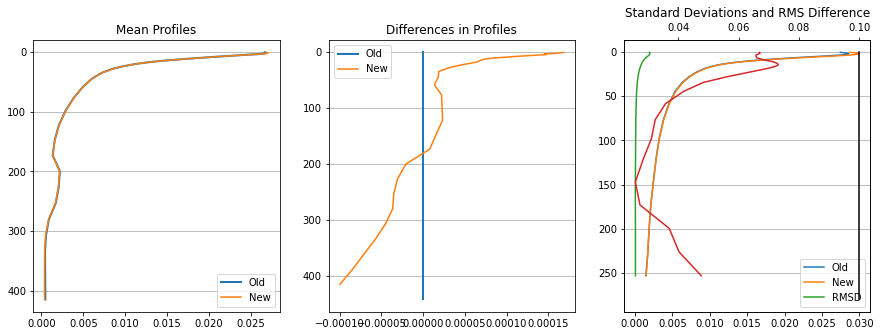

In [18]:
fig = profiles(tracer, file, zmax=33)

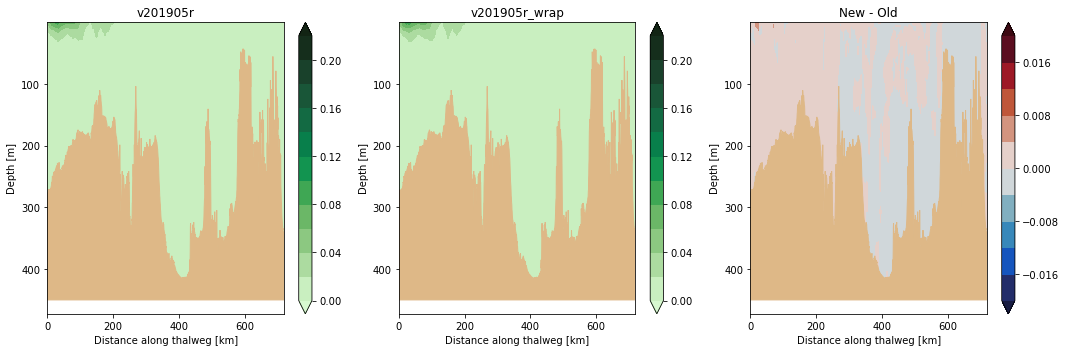

In [19]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: generally more diatoms, max on profile 0.0008 (out of 0.012)
* February: more diatoms in SoG, max on profile 0.0035 (out of 0.035)
* March: a bit high on surface, max on profile 0.03 (out of 0.5)
* April: patchy, max on profile -0.025 (out of 1.75)
* May: patchy, max on profile -0.05 (out of 1.5)
* June: max on profile -0.035 to 0.0(out of 1.5) GOOD
* July: max on profile -0.007 to 0.0 (out of 1.2) GOOD
* August: max on profile -0.014 to 0.0 (out of 0.8) GOOD
* September: max on profile -0.002 to 0.0015(out of 0.35) GOOD
* October: max on profile -0.0001 to 0.00015(out of 0.025) GOOD
* November: max on profile 0 to 0.0012(out of 0.05)
* December: max on profile 0 to 0.00125(out of 0.025)

### Microzooplankton ###

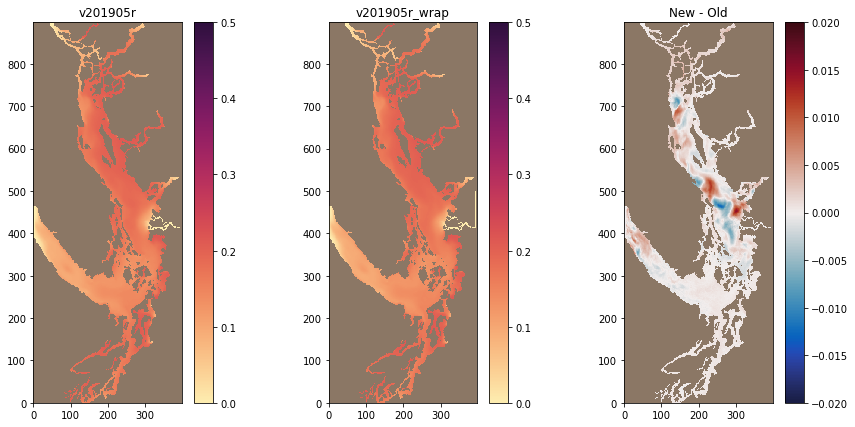

In [20]:
tracer = 'microzooplankton'
file = 'ptrc'
cmap = cm.matter
cmap.set_bad('#8b7765')
cb1 = "Microzooplankton (uM N)"
cdiff = cm.balance
cdiff.set_bad('#8b7765')
cb2 = 'Microzooplankton (uM N)'
vmax = 0.5
vmin = 0
dvmax = 0.02
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.13603284147490569 0.1366763329543328
0.10379756169695156


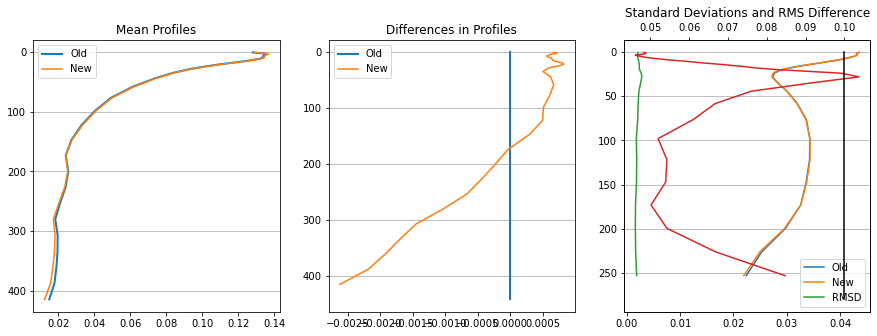

In [21]:
fig = profiles(tracer, file, zmax=33)

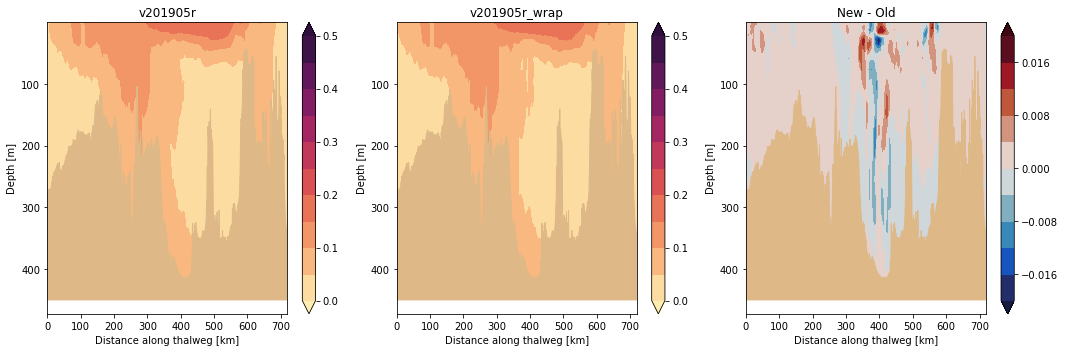

In [22]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: very similar, max on profile -0.0008 to 0.0006 (out of 0.06), good to 20 m
* February: very similar, max on profile -0.002 to 0.0001 (out of 0.12), good to 20 m
* March: very similar, max on profile 0 to 0.005 (out of 0.2), good to 20 m
* April: very similar, max on profile -0.006 to 0.002 (out of 0.7)
* May: very similar, max on profile -0.008 to 0.0 (out of 0.4)
* June: max on profile -0.001 to 0.003 (out of 0.55) good to 15 m
* July: max on profile -0.002 to 0.003 (out of 0.5) good to 20 m: max 0.11
* August: max on profile -0.0017 to 0.0002 (out of 0.45) good to 20m: max 0.11
* September: max on profile -0.002 to 0.0015 (out of 0.25) GOOD
* October: max on profile -0.002 to 0.005 (out of 0.14) mostly good: max < 0.11
* November: max on profile -0.0017 to 0.0007 (out of 0.09)
* December: max on profile -0.0015 to 0.0005 (out of 0.06) mostly good to 180 m

### Salinity ###

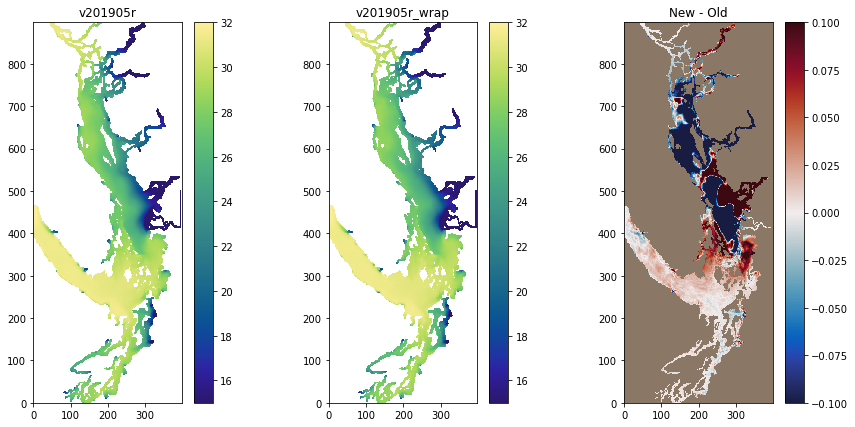

In [23]:
tracer = 'vosaline'
file = 'grid'
cmap = cm.haline
cdiff = cm.balance
vmax = 32
vmin = 15
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

31.886141865897084 31.891689854409538
0.22028885404047646


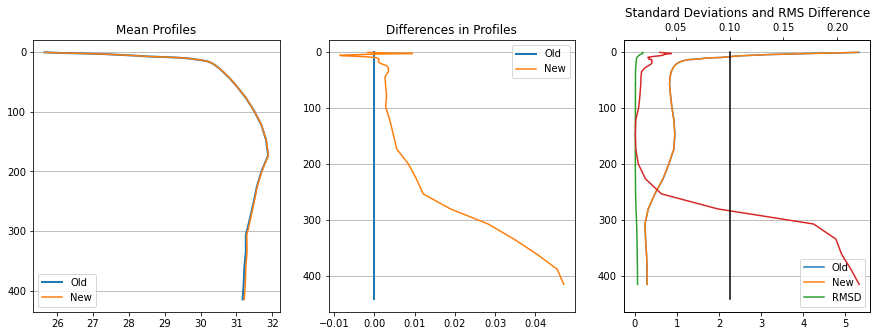

In [24]:
fig = profiles(tracer, file)

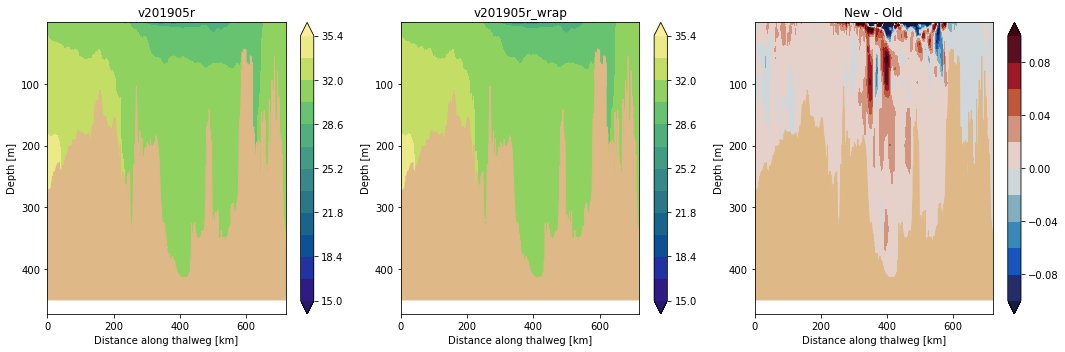

In [25]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: max on profile -0.04 to 0.08(deep value), good above 270 m
* February: max on profile -0.04 to 0.08(deep value), good above 270 m
* March: max on profile -0.04 to 0.075(deep value), good above 270 m
* April: max on profile -0.02 to 0.075(deep value), good above 270 m
* May: max on profile -0.02 to 0.075(deep value), good above 270 m
* June: max on profile -0.02 to 0.075(deep value), good above 270 m
* July: max on profile -0.02 to 0.075(deep value), good above 280 m
* August: max on profile -0.02 to 0.07(deep value), good above 280 m
* September: max on profile -0.02 to 0.065(deep value), good above 280m
* October: max on profile -0.01 to 0.05(deep value), good above 285m
* November: max on profile -0.03 to 0.095(deep value), good above 250 m
* December: max on profile -0.02 to 0.08(deep value), good above 260 m

### Flagellates ###

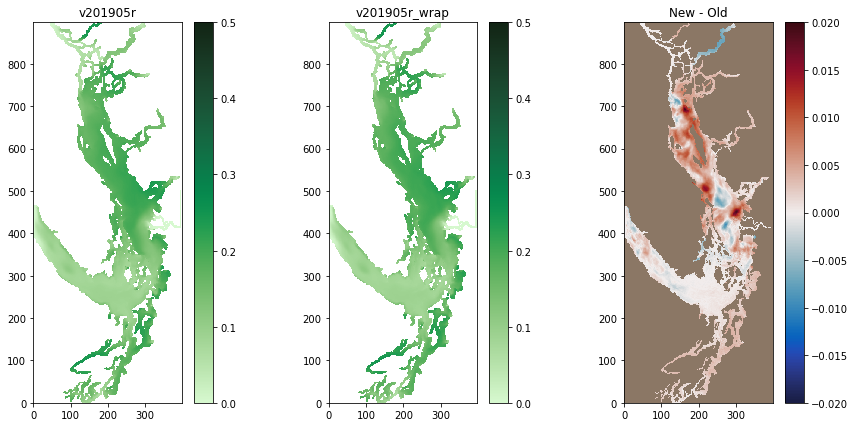

In [28]:
tracer = 'flagellates'
file = 'ptrc'
cmap = cm.algae
cdiff = cm.balance
vmax = 0.5
vmin = 0
dvmax = 0.02
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.12536202314170966 0.1269766117211866
0.1364667647436473


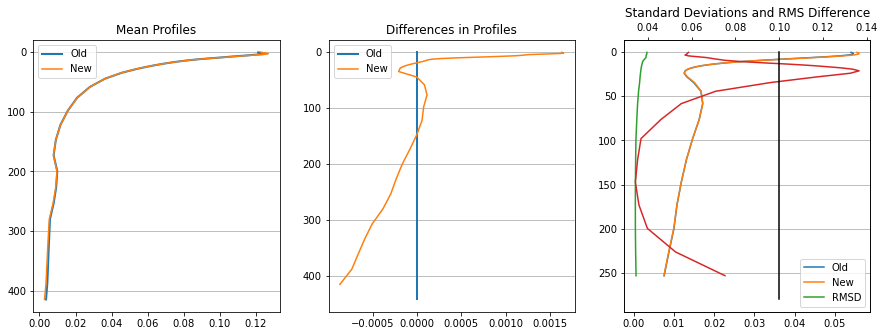

In [29]:
fig = profiles(tracer, file, zmax=33)

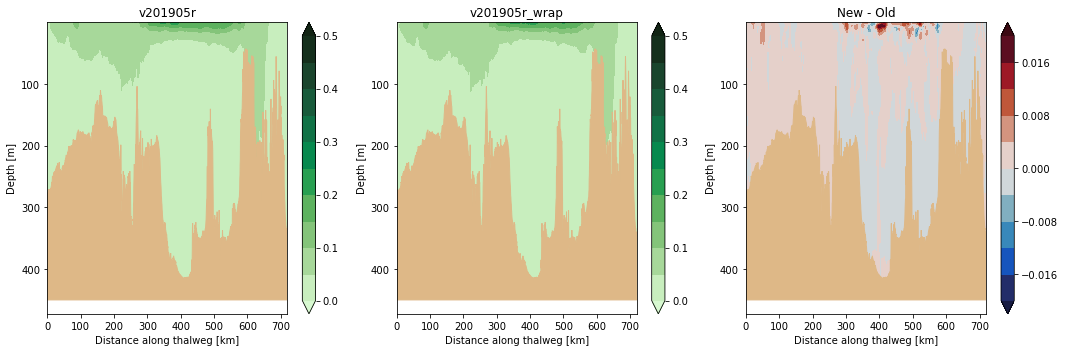

In [30]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: patchy, max on profile -0.0015 to 0.04 (out of 0.2), good to 10 m
* February: patchy, max on profile -0.0008 to 0.0004 (out of 0.25), good to 10 m
* March: very similar, max on profile 0 to 0.006 (out of 0.30), good to 10 m
* April: less flagellates, max on profile -0.006 to 0.0 (out of 0.2)
* May: more flagellates, max on profile -0.0005 to 0.0035 (out of 0.15)
* June: more flagellates, max on profile 0 to 0.055 (out of 1.2), good to 10m
* July: patch, max on profile 0 to 0.02 (out of 1.2), good to 15m, max 0.13
* August: regional, max on profile 0 to 0.02 (out of 1.4), good to 15m, max 0.12
* September: more flagellates, max on profile 0 to 0.02 (out of 0.9), good to 10m, max 0.14
* October: patchy, max on profile -0.0007 to 0.0015 (out of 0.12), good to 10m, max 0.14
* November: patchy, max on profile -0.001 to 0 (out of 0.10)
* December: patchy, max on profile -0.00125 to 0.00025 (out of 0.14) good to 10 m

### NH4 ###

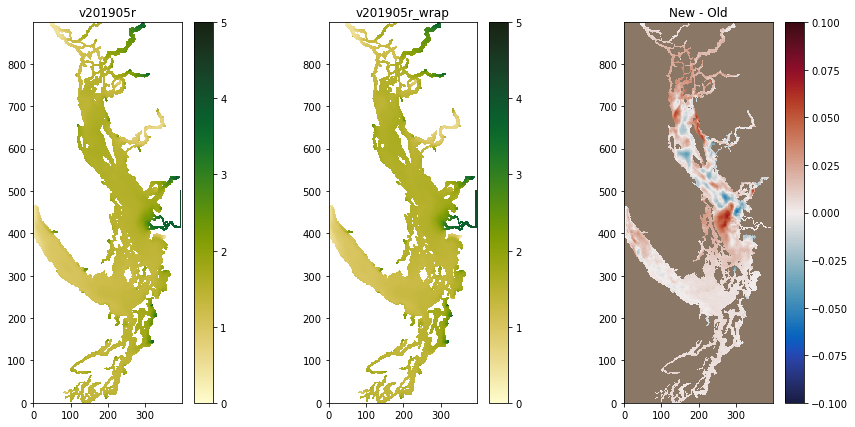

In [31]:
tracer = 'ammonium'
file = 'ptrc'
cmap = cm.speed
cdiff = cm.balance
vmax = 5
vmin = 0
dvmax = 0.1
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

1.5334517532534724 1.539903301915677
0.5714868437568517


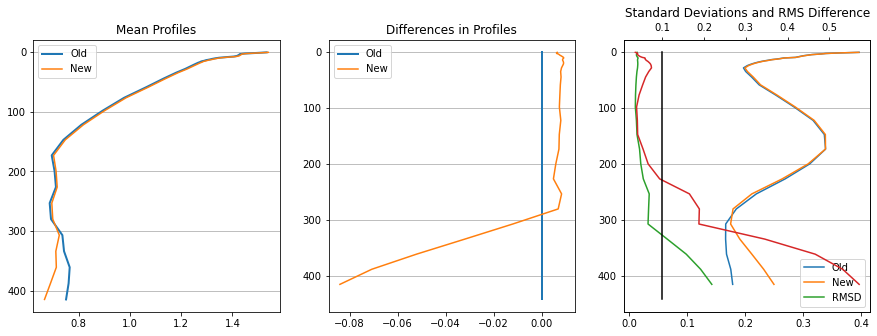

In [32]:
fig = profiles(tracer, file)

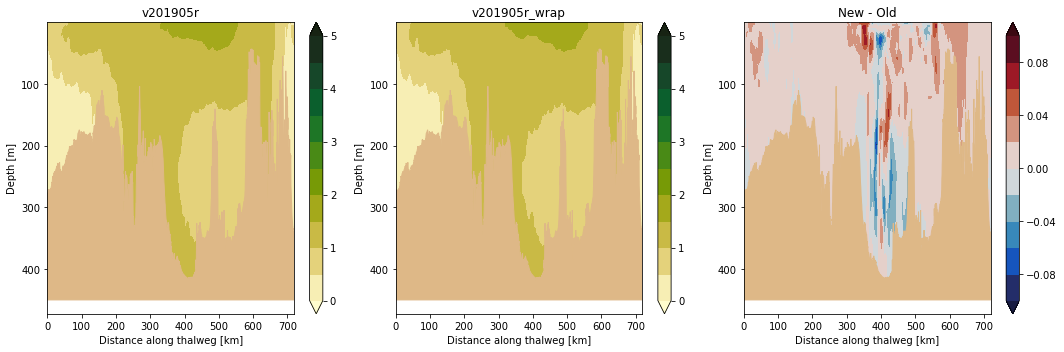

In [33]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### SSH ###

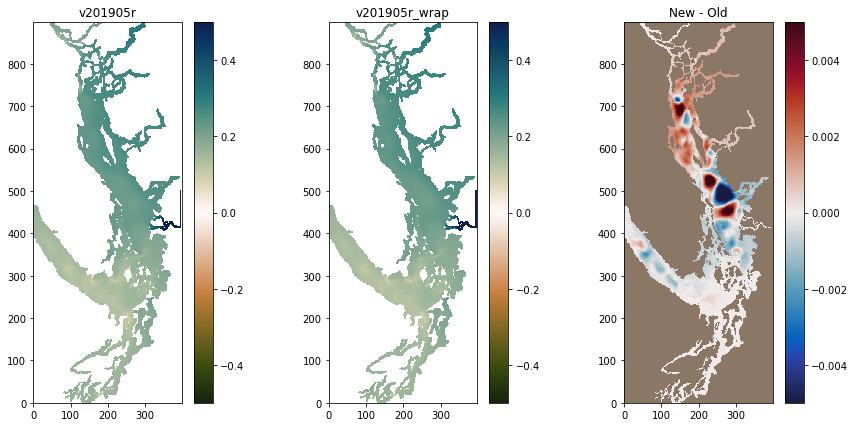

In [34]:
tracer = 'sossheig'
file = 'grid'
cmap = cm.tarn
cdiff = cm.balance
vmax = 0.5
vmin = -0.5
dvmax = 0.005
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, twoD=True)

### Oxygen ###

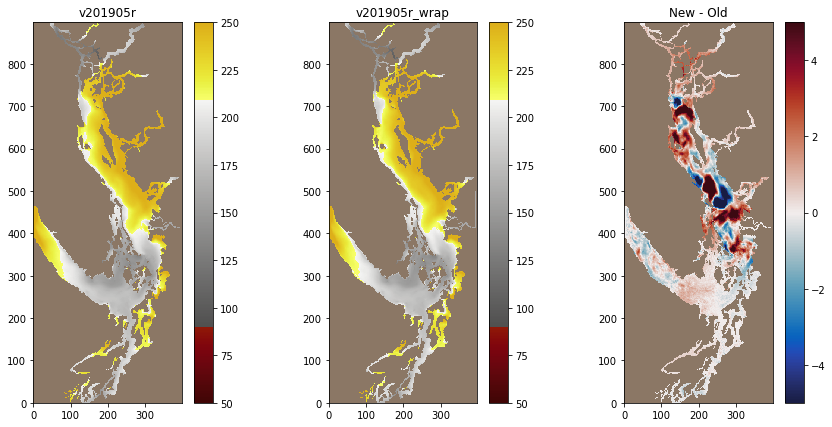

In [35]:
tracer = 'dissolved_oxygen'
file = 'carp'
cmap = cm.oxy
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 250
vmin = 50
dvmax = 5
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

205.52660062579727 205.8614172314521
0.8654557205793614


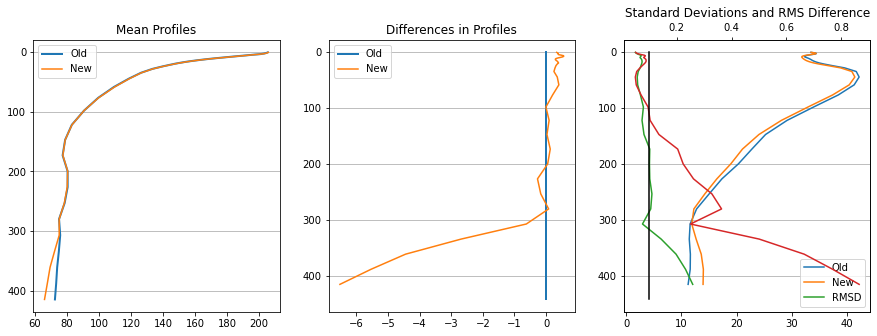

In [36]:
fig = profiles(tracer, file)

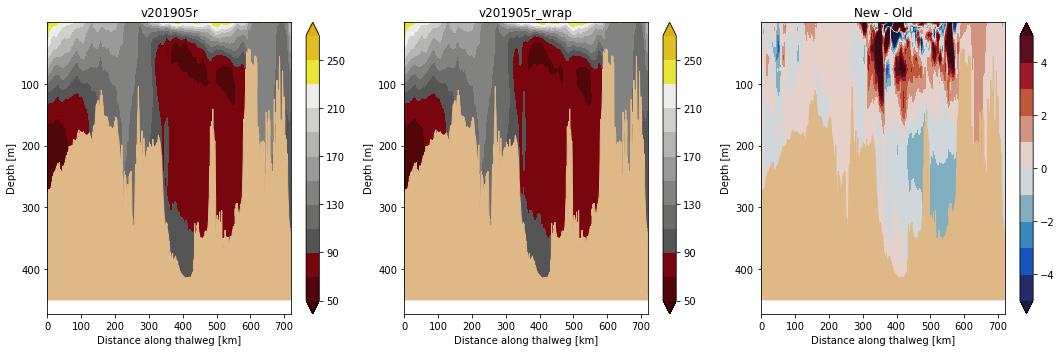

In [37]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

* January: patchy, max on profile -1.5 to 3 (out of 225) good to 5 m
* February: patchy, max on profile -0.5 to 2.5 (out of 250), mostly good to 20 m
* March: patchy, max on profile -1 to 1.8(deep) 3 (out of 280), good to 20 m
* April: more oxygen at 70 m in SoG, max on profile -0.7 to 2(deep) (out of 300)
* May: max on profile -0.5 to 2.7(deep) (out of 280), mostly good to 100 m
* June: max on profile 0 to 3(deep) (out of 270), good to 20 m
* July: max on profile 0 to 2.7(deep) (out of 250), good to 15 m
* August: max on profile -0.2 to 3.5(deep) (out of 250), mostly good to 90 m
* September: max on profile -0.7 to 1.2(deep)to 1.5(out of 225), good to 80m
* October: max on profile -6(deep) to 0.5 (out of 200): good to 120m
* November: surface similar, more oxygen at 70 m in SoG, max on profile 1 to 7(deep) (out of 210)
* December: profile looks good, more at 80 m, less at 300 m, max on profile -0.5 to 1.7(deep) to 2.5, good to 5 m

### PON ###

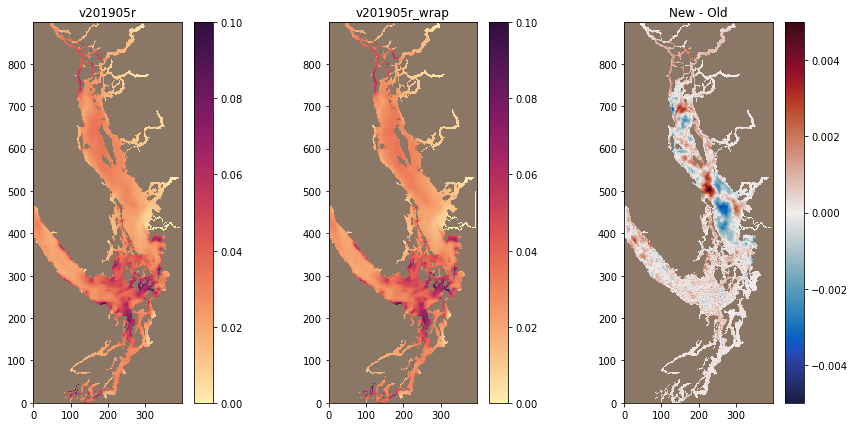

In [41]:
tracer = 'particulate_organic_nitrogen'
file = 'ptrc'
cmap = cm.matter
cdiff = cm.balance
vmax = 0.1
vmin = 0
dvmax = 0.005
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

0.07552410747354094 0.07659114470151816
0.134753080827058


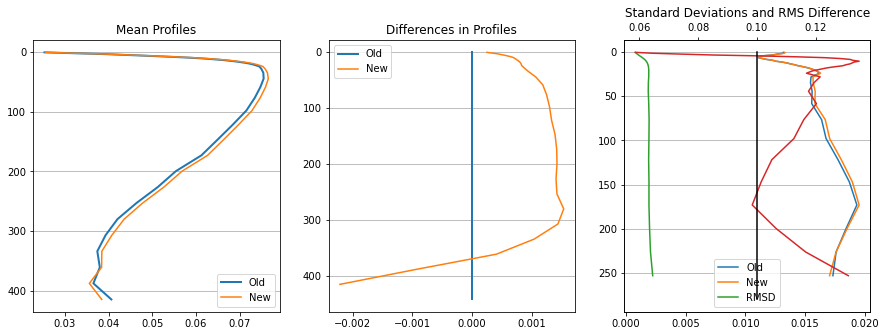

In [42]:
fig = profiles(tracer, file, zmax=33)

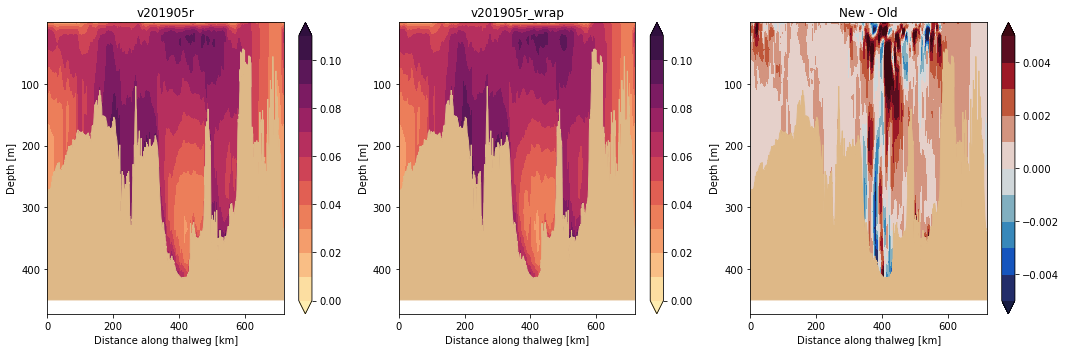

In [43]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Silicon ###

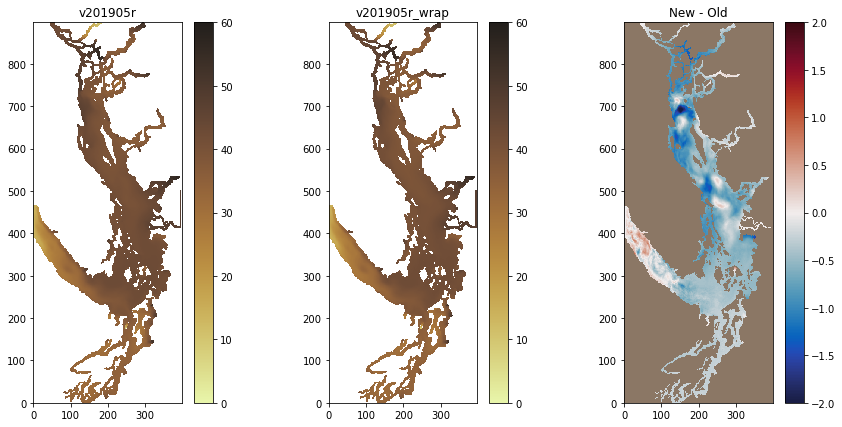

In [44]:
tracer = 'silicon'
file = 'ptrc'
cmap = cm.turbid
cdiff = cm.balance
vmax = 60
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

68.52677007823267 78.7023465394144
0.8977219261054196


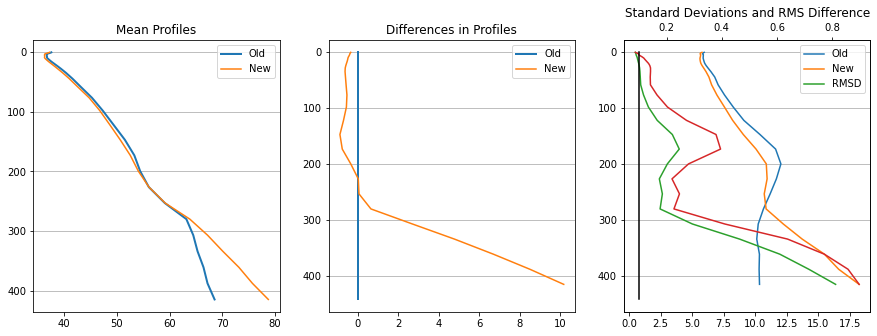

In [45]:
fig = profiles(tracer, file)

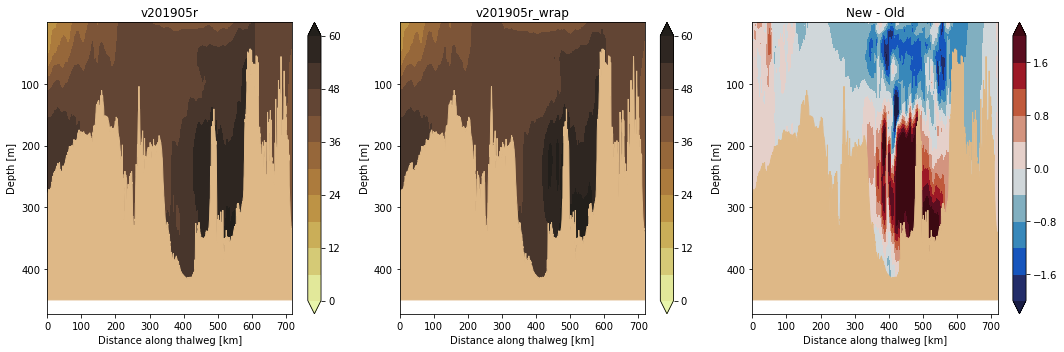

In [46]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### DIC ###

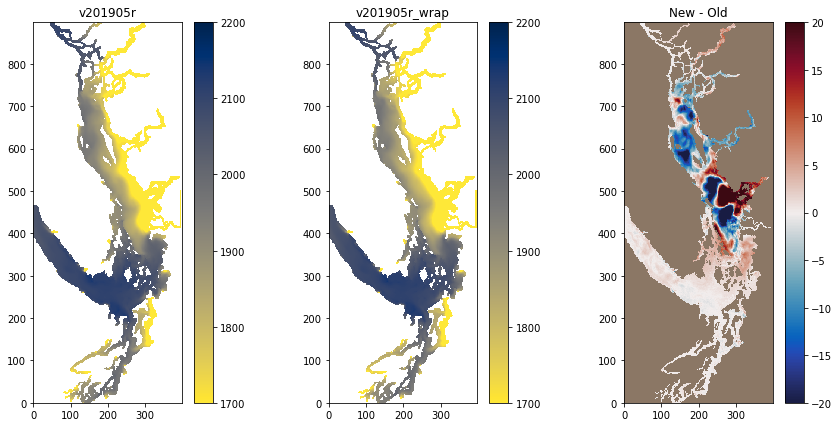

In [47]:
tracer = 'dissolved_inorganic_carbon'
file = 'carp'
cmap = 'cividis_r'
cdiff = cm.balance
vmax = 2200
vmin = 1700
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2190.313781578003 2192.075484852487
0.7943181580976975


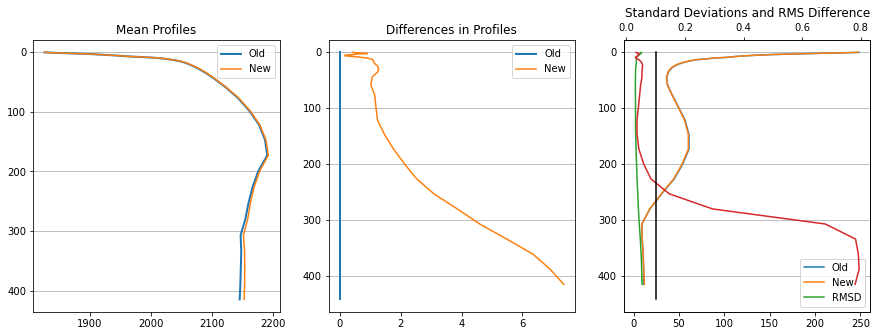

In [48]:
fig = profiles(tracer, file)

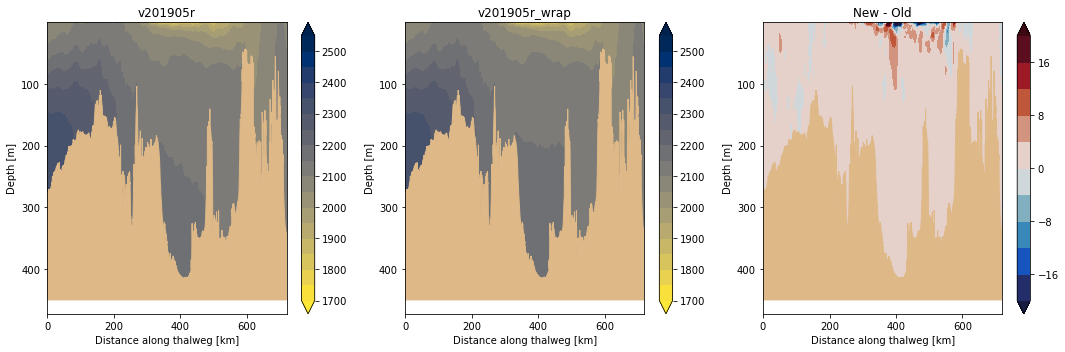

In [49]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Alkalinity ###

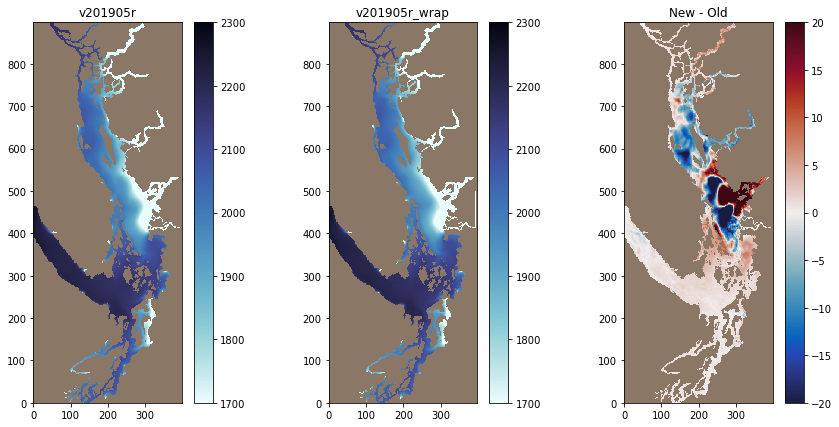

In [50]:
tracer = 'total_alkalinity'
file = 'carp'
cmap = cm.ice_r
cmap.set_bad('#8b7765')
cdiff = cm.balance
vmax = 2300
vmin = 1700
dvmax = 20
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax)

2215.3692004975037 2217.1268453043926
0.39153139597754866


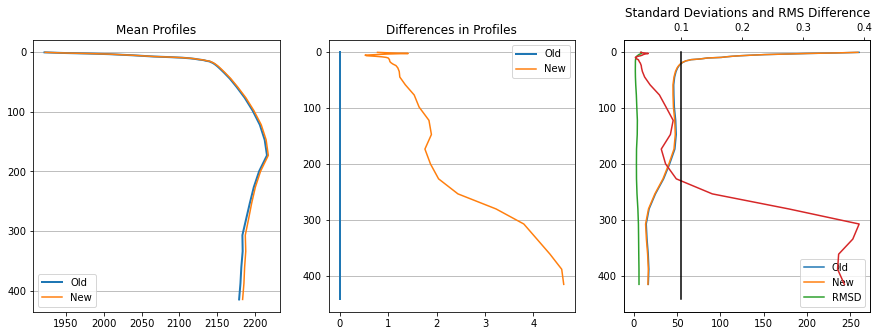

In [51]:
fig = profiles(tracer, file)

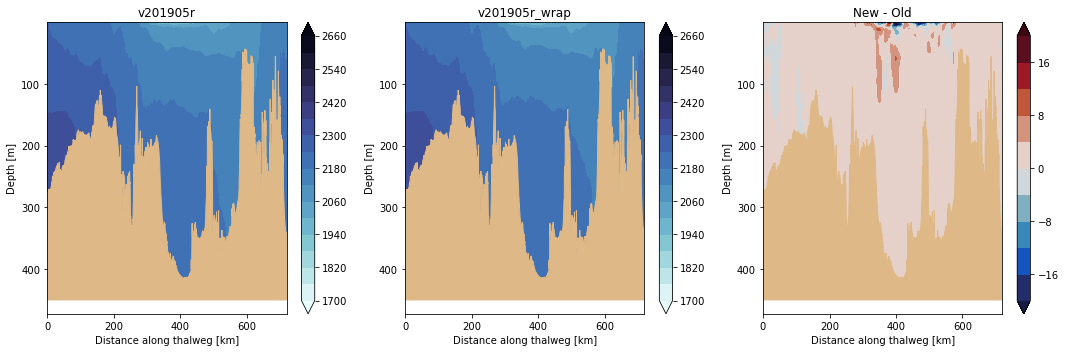

In [52]:
fig = thalweg_plots(tracer, file, cmap, cdiff, vmax, vmin, dvmax)

### Fraser Tracer ###

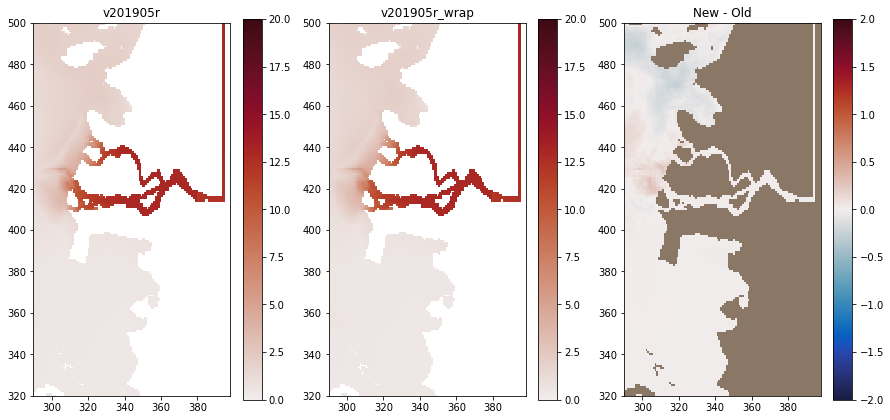

In [53]:
tracer = 'Fraser_tracer'
file = 'carp'
cmap = cm.amp
cdiff = cm.balance
vmax = 20
vmin = 0
dvmax = 2
fig = surface_plots(tracer, file, month, cmap, cdiff, vmax, vmin, dvmax, dl=3,
                    zoom=[320, 500, 290, 398])